In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt


def visualize_json_grid(json_path: str, cmap: str = "gray"):
    # 1) JSON 로드
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    print(f"[+] Loaded {len(data)} cells from JSON")

    # 2) "(x, y)" -> 정수 좌표 변환
    xs, ys, vals = [], [], []

    for k, v in data.items():
        k_clean = k.strip("()")
        x_str, y_str = k_clean.split(",")
        xs.append(int(x_str))
        ys.append(int(y_str))
        vals.append(v)

    xs = np.array(xs)
    ys = np.array(ys)
    vals = np.array(vals, dtype=float)

    # 3) 좌표 shift (min을 0으로)
    x_min, y_min = xs.min(), ys.min()
    xs_shift = xs - x_min
    ys_shift = ys - y_min

    nx = xs_shift.max() + 1
    ny = ys_shift.max() + 1
    print("grid size (ny, nx):", ny, nx)

    # 4) 2D grid 생성
    grid = np.zeros((ny, nx), dtype=float)
    for x_s, y_s, v in zip(xs_shift, ys_shift, vals):
        grid[y_s, x_s] = v  # (행, 열) = (y, x)

    # 5) 시각화 (타이틀 없이)
    plt.figure(figsize=(6, 6))
    plt.imshow(grid, origin="lower", cmap=cmap)
    plt.colorbar(label="value")
    plt.xlabel("x (shifted)")
    plt.ylabel("y (shifted)")
    plt.grid(False)
    plt.show()

    return grid

In [2]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

def visualize_pcd(pcd_path: str,
                  max_points: int = 200_000,
                  use_rgb_if_available: bool = True,
                  show_3d: bool = False):

    # 1) PCD 로드
    pcd = o3d.io.read_point_cloud(pcd_path)

    if pcd.is_empty():
        raise RuntimeError(f"[!] Failed to load or empty PCD: {pcd_path}")

    pts = np.asarray(pcd.points)  # (N, 3)
    N = pts.shape[0]
    print(f"[+] Loaded point cloud: {N} points")

    # 2) 색 정보 처리
    if use_rgb_if_available and pcd.has_colors():
        colors = np.asarray(pcd.colors)  # (N, 3), 0~1
        print("[+] Color information found in PCD (using RGB).")
    else:
        print("[!] No usable color information. Using gray.")
        colors = np.tile([[0.5, 0.5, 0.5]], (N, 1))  # 회색

    # 3) 샘플링 (옵션)
    if N > max_points:
        idx = np.random.choice(N, max_points, replace=False)
        pts_vis = pts[idx]
        colors_vis = colors[idx]
        print(f"    → subsampled from {N} to {pts_vis.shape[0]} points for plotting")
    else:
        pts_vis = pts
        colors_vis = colors

    # 4) Top-down (XY) 시각화
    x = pts_vis[:, 0]
    y = pts_vis[:, 1]

    print(f"X range: {x.min():.3f} → {x.max():.3f}")
    print(f"Y range: {y.min():.3f} → {y.max():.3f}")

    plt.figure(figsize=(8, 8))
    plt.scatter(x, y, c=colors_vis, s=1)
    plt.axis("equal")
    plt.xlabel("X")
    plt.ylabel("Y")
    # 타이틀 없음 (요청 스타일에 맞춰)
    plt.grid(False)
    plt.show()

    # 5) 3D 시각화 (옵션)
    if show_3d:
        from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(pts_vis[:, 0], pts_vis[:, 1], pts_vis[:, 2],
                   c=colors_vis, s=1)
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        # 타이틀 없음
        plt.show()

    return pts_vis, colors_vis


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


[+] Loaded 2893 cells from JSON
grid size (ny, nx): 105 65


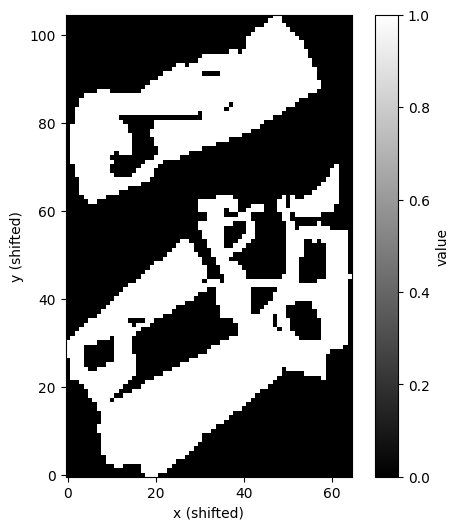

[+] Loaded point cloud: 2668450 points
[+] Color information found in PCD (using RGB).
    → subsampled from 2668450 to 200000 points for plotting
X range: 77.850 → 389.980
Y range: 107.800 → 612.120


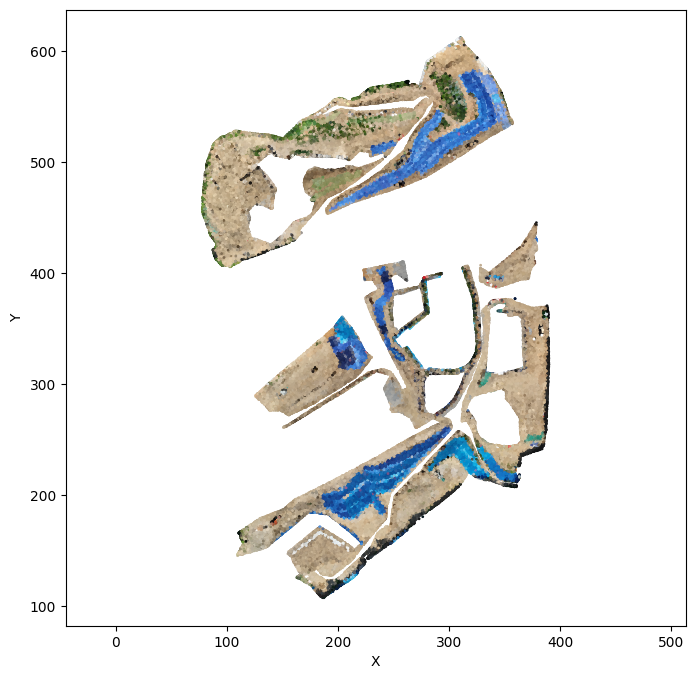

In [3]:
installable = visualize_json_grid(json_path="/workspace/MAPS/seocho/installable_map/installable_grid.json")
pts_vis, colors_vis = visualize_pcd(
    "/workspace/MAPS/seocho/installable_map/installable_map.pcd",
    max_points=200_000,
    use_rgb_if_available=True,
    show_3d=False
)


[+] Loaded 4027 cells from JSON
grid size (ny, nx): 117 81


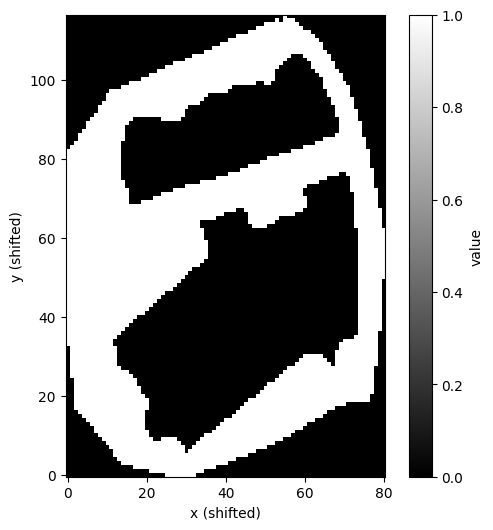

[+] Loaded point cloud: 7926843 points
[+] Color information found in PCD (using RGB).
    → subsampled from 7926843 to 200000 points for plotting
X range: 15.260 → 418.360
Y range: 67.230 → 646.360


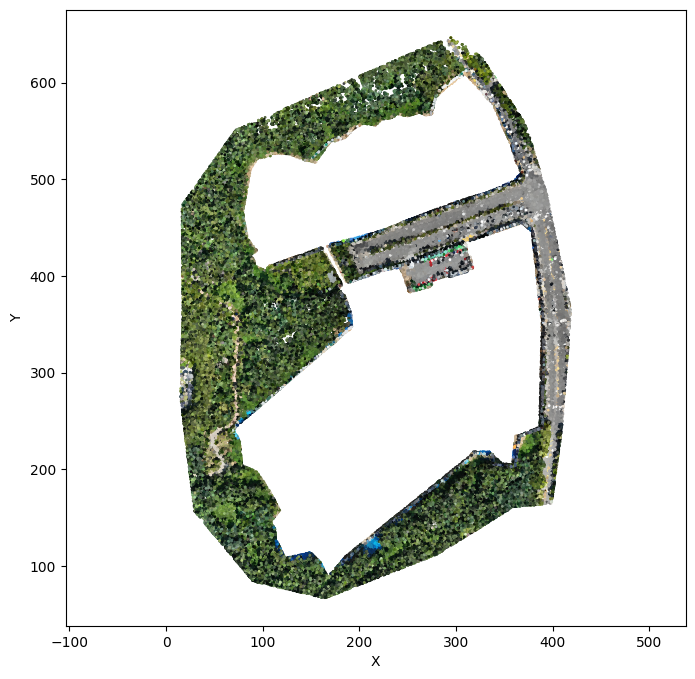

In [4]:
ignore = visualize_json_grid(json_path="/workspace/MAPS/seocho/ignore_map/ignore_grid.json")
pts_vis, colors_vis = visualize_pcd(
    "/workspace/MAPS/seocho/ignore_map/ignore_map.pcd",
    max_points=200_000,
    use_rgb_if_available=True,
    show_3d=False
)

[+] Loaded point cloud: 13078365 points
[+] Color information found in PCD (using RGB).
    → subsampled from 13078365 to 200000 points for plotting
X range: 15.310 → 418.650
Y range: 67.450 → 646.250


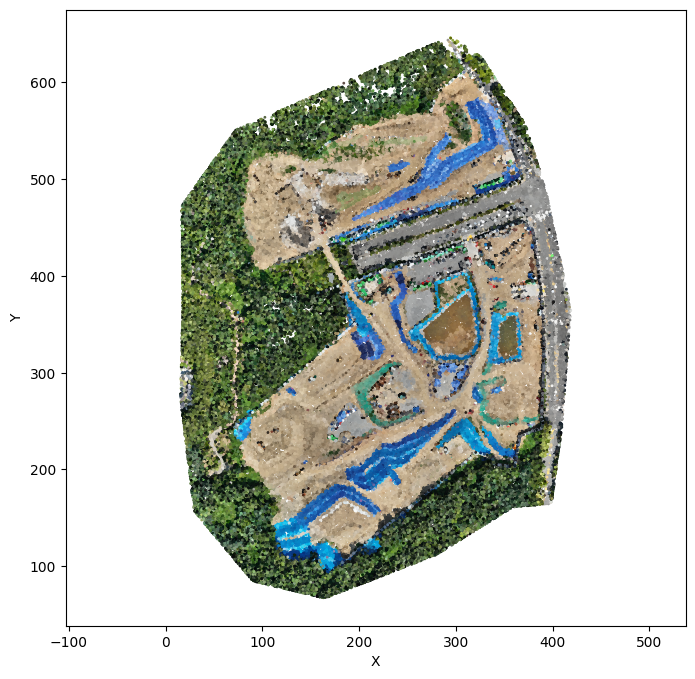

In [5]:
pts_vis, colors_vis = visualize_pcd(
    "/workspace/PCD_FILES/seocho.pcd",
    max_points=200_000,
    use_rgb_if_available=True,
    show_3d=False
)

In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt


def build_combined_grid(installable_json_path: str,
                        ignore_json_path: str,
                        visualize: bool = True):
    """
    installable / ignore JSON을 합쳐서 2D 그리드(파이썬 리스트) 생성.

    - installable JSON: 해당 좌표는 1
    - ignore JSON: 해당 좌표는 0
    - 두 JSON 어디에도 없는 좌표: None

    좌표는 JSON 키 "(x, y)" 를 그대로 사용하고,
    전체 bounding box 기준으로 [ny][nx] 그리드를 만든다.

    Returns
    -------
    grid : list[list[Optional[int]]]
        0/1/None 값이 들어있는 2D 리스트.
    meta : dict
        bounding box 정보 (x_min, x_max, y_min, y_max, nx, ny)
    """

    # ---------- 1) JSON 로드 + 좌표 파싱 ----------
    def load_coords(path):
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        coords = {}
        for k, v in data.items():
            if not v:
                # 값이 0 / False면 스킵 (원하면 포함시켜도 됨)
                continue
            k_clean = k.strip("()")
            x_str, y_str = k_clean.split(",")
            x = int(x_str)
            y = int(y_str)
            coords[(x, y)] = v
        return coords

    install_coords = load_coords(installable_json_path)
    ignore_coords = load_coords(ignore_json_path)

    print(f"[+] installable cells: {len(install_coords)}")
    print(f"[+] ignore cells     : {len(ignore_coords)}")

    # ---------- 2) 전체 범위(bounding box) 계산 ----------
    all_points = list(install_coords.keys()) + list(ignore_coords.keys())
    xs = [p[0] for p in all_points]
    ys = [p[1] for p in all_points]

    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)

    nx = (x_max - x_min) + 1
    ny = (y_max - y_min) + 1

    print(f"[+] global x range: {x_min} → {x_max}  (nx={nx})")
    print(f"[+] global y range: {y_min} → {y_max}  (ny={ny})")

    # ---------- 3) 2D 파이썬 리스트 생성 (기본값: None) ----------
    grid = [[None for _ in range(nx)] for _ in range(ny)]

    # ---------- 4) ignore = 0, installable = 1 채우기 ----------
    for (x, y) in ignore_coords.keys():
        gx = x - x_min
        gy = y - y_min
        grid[gy][gx] = 0  # ignore

    for (x, y) in install_coords.keys():
        gx = x - x_min
        gy = y - y_min
        grid[gy][gx] = 1  # installable (우선순위 높게 덮어쓰기)

    # ---------- 5) (옵션) 시각화 ----------
    if visualize:
        vis_arr = np.full((ny, nx), np.nan, dtype=float)
        for j in range(ny):
            for i in range(nx):
                v = grid[j][i]
                if v is not None:
                    vis_arr[j, i] = v

        plt.figure(figsize=(6, 6))
        im = plt.imshow(vis_arr, origin="lower", cmap="viridis")
        plt.colorbar(im, label="grid value (None=NaN, 0=ignore, 1=installable)")
        plt.xlabel("x (shifted index)")
        plt.ylabel("y (shifted index)")
        plt.grid(False)
        plt.show()

    meta = {
        "x_min": x_min,
        "x_max": x_max,
        "y_min": y_min,
        "y_max": y_max,
        "nx": nx,
        "ny": ny,
    }

    return grid, meta


[+] installable cells: 2893
[+] ignore cells     : 4027
[+] global x range: 0 → 80  (nx=81)
[+] global y range: 0 → 116  (ny=117)


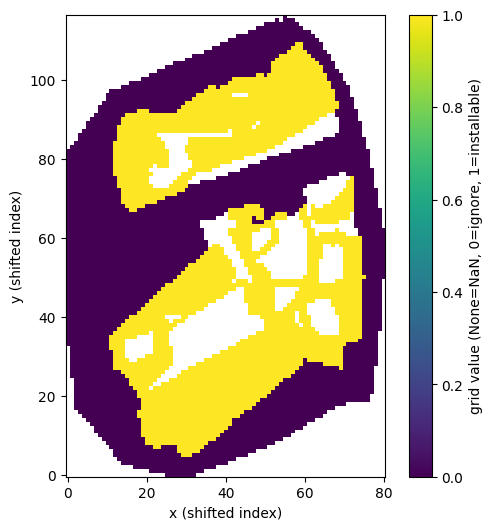

<class 'list'> 117 81
예시 값들: [None, None, None, None, None, None, None, None, None, None]


In [7]:
combined_grid, meta = build_combined_grid(
    installable_json_path="/workspace/MAPS/seocho/installable_map/installable_grid.json",
    ignore_json_path="/workspace/MAPS/seocho/ignore_map/ignore_grid.json",
    visualize=True
)

# combined_grid는 파이썬 리스트 (ny x nx), 값은 {None, 0, 1}
print(type(combined_grid), len(combined_grid), len(combined_grid[0]))
print("예시 값들:", combined_grid[0][:10])


In [8]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt


def select_cells_on_grid(grid,
                         meta: dict,
                         output_json_path: str = "selected_cells.json",
                         value: int = 1):
    """
    결합된 grid를 화면에 띄우고, 마우스로 찍은 셀들을 모아서
    (x, y) -> value 형태의 JSON으로 저장하는 함수.

    - grid: build_combined_grid 에서 나온 2D 리스트 (ny x nx, 값: None/0/1)
    - meta: build_combined_grid 가 리턴한 메타정보 (x_min, y_min, nx, ny 등)
    - output_json_path: 저장할 JSON 경로
    - value: 선택된 셀에 넣을 값 (보통 1)

    사용법:
    - 플롯 창에서 왼쪽 클릭: 셀 선택/해제 (토글)
    - 그림 창을 직접 닫으면(창 X 버튼) 선택 종료 & JSON 저장
    """

    x_min = meta["x_min"]
    y_min = meta["y_min"]
    ny = meta["ny"]
    nx = meta["nx"]

    # ----- 1) 시각화용 배열 생성 (기존 grid 값 유지) -----
    vis_arr_base = np.full((ny, nx), np.nan, dtype=float)
    for j in range(ny):
        for i in range(nx):
            v = grid[j][i]
            if v is not None:
                vis_arr_base[j, i] = v

    # 선택 상태 표시용 배열
    vis_arr = vis_arr_base.copy()

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(vis_arr, origin="lower", cmap="viridis")
    plt.colorbar(
        im,
        ax=ax,
        label="grid value (None=NaN, 0=ignore, 1=installable, 2=selected)"
    )
    ax.set_xlabel("x (shifted index)")
    ax.set_ylabel("y (shifted index)")
    ax.grid(False)
    ax.set_title("Left-click: select/toggle cell, Close window to finish")

    # 선택된 셀들 (grid index 기준: (ix, iy))
    selected = set()

    def update_image():
        """선택된 셀을 색깔(2.0)로 표시하고 전체 이미지 갱신"""
        vis_arr[:, :] = vis_arr_base
        for (ix, iy) in selected:
            vis_arr[iy, ix] = 2.0  # 선택된 셀을 별도 값으로 표시
        im.set_array(vis_arr)
        fig.canvas.draw_idle()

    def onclick(event):
        # 축 밖 클릭 무시
        if event.inaxes != ax:
            return
        if event.xdata is None or event.ydata is None:
            return

        ix = int(round(event.xdata))
        iy = int(round(event.ydata))

        # 범위 체크
        if ix < 0 or ix >= nx or iy < 0 or iy >= ny:
            return

        key = (ix, iy)
        if key in selected:
            selected.remove(key)   # 다시 누르면 취소
        else:
            selected.add(key)      # 새로 선택

        update_image()

    cid_click = fig.canvas.mpl_connect("button_press_event", onclick)

    print("[INFO] 그림 창에서 셀을 클릭해서 선택하고, 다 끝나면 창을 닫으세요.")
    plt.show()

    # 이벤트 핸들러 해제
    fig.canvas.mpl_disconnect(cid_click)

    # ----- 2) 선택된 셀들을 원래 좌표계 (x, y)로 변환해서 JSON 구성 -----
    result_dict = {}
    for (ix, iy) in selected:
        x = ix + x_min
        y = iy + y_min
        key_str = f"({x}, {y})"
        result_dict[key_str] = value

    print(f"[+] Selected {len(result_dict)} cells.")
    print(f"[+] Saving JSON to: {output_json_path}")

    # 상위 디렉토리 생성
    dirpath = os.path.dirname(output_json_path)
    if dirpath:
        os.makedirs(dirpath, exist_ok=True)

    with open(output_json_path, "w", encoding="utf-8") as f:
        json.dump(result_dict, f, ensure_ascii=False, indent=2)

    return result_dict


[+] installable cells: 2893
[+] ignore cells     : 4027
[+] global x range: 0 → 80  (nx=81)
[+] global y range: 0 → 116  (ny=117)


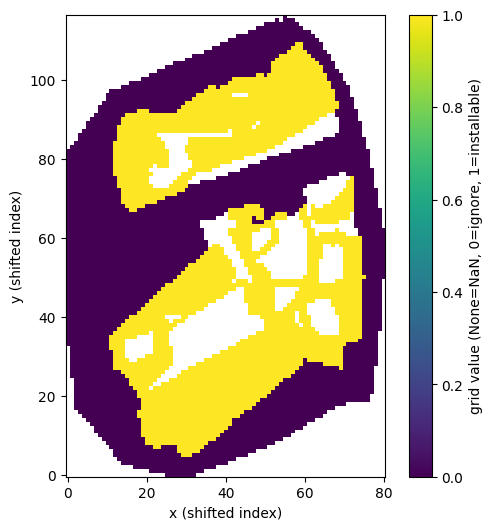

[INFO] 그림 창에서 셀을 클릭해서 선택하고, 다 끝나면 창을 닫으세요.


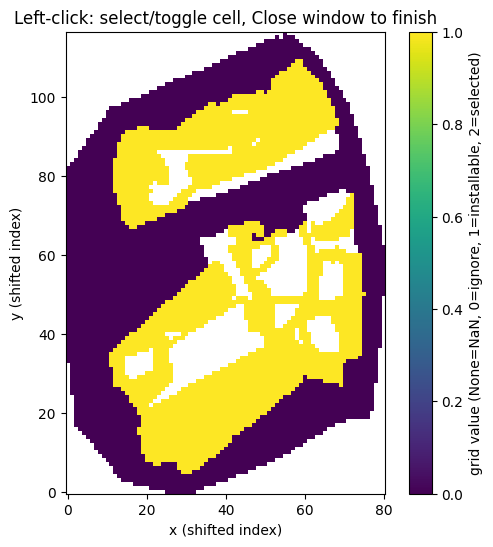

[+] Selected 0 cells.
[+] Saving JSON to: /workspace/MAPS/selected_cells.json


In [9]:
combined_grid, meta = build_combined_grid(
    installable_json_path="/workspace/MAPS/seocho/installable_map/installable_grid.json",
    ignore_json_path="/workspace/MAPS/seocho/ignore_map/ignore_grid.json",
    visualize=True
)

# 마우스로 찍어서 새로운 맵 데이터 만들기
selected_map = select_cells_on_grid(
    combined_grid,
    meta,
    output_json_path="/workspace/MAPS/selected_cells.json",
    value=1  # 클릭한 셀에 넣을 값
)


In [10]:
from collections import deque
import numpy as np

def fill_interior_nulls(grid, interior_value: int = 2):
    """
    grid: 2D list (ny x nx), 값은 {None, 0, 1} 등
    - 바깥에서 연결된 None 은 그대로 유지 (외부)
    - 바깥과 연결되지 않은 None 은 '구멍'으로 보고 interior_value로 채움
    """
    ny = len(grid)
    nx = len(grid[0])

    # None인 위치를 True로 하는 마스크
    is_none = np.zeros((ny, nx), dtype=bool)
    for j in range(ny):
        for i in range(nx):
            if grid[j][i] is None:
                is_none[j, i] = True

    visited = np.zeros_like(is_none, dtype=bool)
    q = deque()

    # 1) 경계(border)에 있는 None들을 큐에 넣고 BFS 시작 (외부 None)
    for x in range(nx):
        if is_none[0, x]:
            q.append((0, x))
            visited[0, x] = True
        if is_none[ny - 1, x]:
            if not visited[ny - 1, x]:
                q.append((ny - 1, x))
                visited[ny - 1, x] = True

    for y in range(ny):
        if is_none[y, 0] and not visited[y, 0]:
            q.append((y, 0))
            visited[y, 0] = True
        if is_none[y, nx - 1] and not visited[y, nx - 1]:
            q.append((y, nx - 1))
            visited[y, nx - 1] = True

    # 4-방향 탐색
    dirs = [(1, 0), (-1, 0), (0, 1), (0, -1)]

    while q:
        cy, cx = q.popleft()
        for dy, dx in dirs:
            nyy = cy + dy
            nxx = cx + dx
            if 0 <= nyy < ny and 0 <= nxx < nx:
                if is_none[nyy, nxx] and not visited[nyy, nxx]:
                    visited[nyy, nxx] = True
                    q.append((nyy, nxx))

    # visited == True 인 None 은 "외부와 연결된 None"
    # visited == False 이면서 None 인 셀은 "내부 구멍" → interior_value 로 채움
    fill_count = 0
    for j in range(ny):
        for i in range(nx):
            if is_none[j, i] and not visited[j, i]:
                grid[j][i] = interior_value
                fill_count += 1

    print(f"[+] Filled {fill_count} interior None cells with value={interior_value}")
    return grid


[+] installable cells: 2893
[+] ignore cells     : 4027
[+] global x range: 0 → 80  (nx=81)
[+] global y range: 0 → 116  (ny=117)


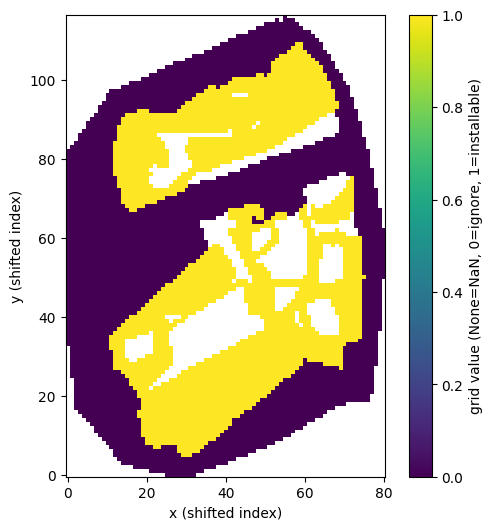

[+] Filled 1020 interior None cells with value=2


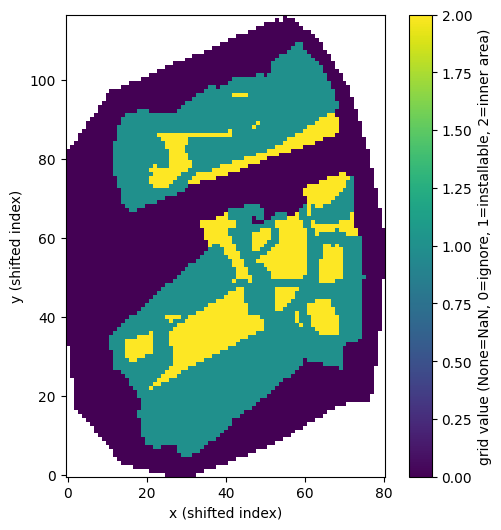

In [11]:
combined_grid, meta = build_combined_grid(
    installable_json_path="/workspace/MAPS/seocho/installable_map/installable_grid.json",
    ignore_json_path="/workspace/MAPS/seocho/ignore_map/ignore_grid.json",
    visualize=True
)

# 🔹 내부 null(구멍)들을 2로 채우기
combined_grid = fill_interior_nulls(combined_grid, interior_value=2)

# (원하면 다시 시각화)
ny = meta["ny"]
nx = meta["nx"]
vis_arr = np.full((ny, nx), np.nan, dtype=float)
for j in range(ny):
    for i in range(nx):
        v = combined_grid[j][i]
        if v is not None:
            vis_arr[j, i] = v

plt.figure(figsize=(6, 6))
im = plt.imshow(vis_arr, origin="lower", cmap="viridis")
plt.colorbar(im, label="grid value (None=NaN, 0=ignore, 1=installable, 2=inner area)")
plt.xlabel("x (shifted index)")
plt.ylabel("y (shifted index)")
plt.grid(False)
plt.show()


In [13]:
def save_grid_as_py_module(grid, output_path: str, var_name: str = "GRID"):
    """
    2D 리스트를 .py 파일로 저장해서 나중에 import 해서 쓰는 용도.
    예: var_name="SEOCHO_GRID" 등.
    """
    import pprint
    dirpath = os.path.dirname(output_path)
    if dirpath:
        os.makedirs(dirpath, exist_ok=True)

    with open(output_path, "w", encoding="utf-8") as f:
        f.write("# Auto-generated grid data\n")
        f.write(f"{var_name} = ")
        pprint.pprint(grid, stream=f, width=120)  # 보기 좋게 포맷
    print(f"[+] Saved grid as python module to: {output_path}")


In [14]:
combined_grid = fill_interior_nulls(combined_grid, interior_value=2)

save_grid_as_py_module(
    combined_grid,
    "/workspace/MAPS/seocho/combined_grid.py",
    var_name="SEOCHO_GRID"
)


[+] Filled 0 interior None cells with value=2
[+] Saved grid as python module to: /workspace/MAPS/seocho/combined_grid.py
